<h1>Home Credit Default Risk Prediction</h1>

In [70]:
import sklearn
import imblearn
print("scikit-learn:", sklearn.__version__)
print("imblearn:", imblearn.__version__)


scikit-learn: 1.4.2
imblearn: 0.12.3


In [3]:
import os
import gc
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc, accuracy_score,
    precision_score, recall_score, f1_score, classification_report,
    confusion_matrix
)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from imblearn.over_sampling import SMOTE

import joblib


In [7]:
import shap
try:
    from lime import lime_tabular
    LIME_AVAILABLE = True
except Exception:
    LIME_AVAILABLE = False

<h2>Dataset and Setup</h2>

In [8]:
INPUT = "/kaggle/input/loan-default/home-credit-default-risk/application_train.csv"   # update path if needed
RANDOM_STATE = 69
SAMPLE_FRAC = 0.4   # set 0.1 to use 10% for fast experiments, or None for full dataset
TARGET = "TARGET"
ID_COL = "SK_ID_CURR"

assert os.path.exists(INPUT), f"Input file not found: {INPUT}"

print("Loading data...")
df = pd.read_csv(INPUT)
print("Original shape:", df.shape)

if SAMPLE_FRAC is not None:
    df = df.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE).reset_index(drop=True)
    print("Sampled shape:", df.shape)



Loading data...
Original shape: (307511, 122)
Sampled shape: (123004, 122)


<h2>Data Preprocessing</h2>

In [9]:
# Drop columns with too many missing values (>90%)
missing_ratio = df.isnull().mean()
drop_cols = missing_ratio[missing_ratio > 0.90].index.tolist()
print(f"Dropping {len(drop_cols)} cols with >90% missing")
df = df.drop(columns=drop_cols)

Dropping 0 cols with >90% missing


In [10]:
# Drop identifiers
if ID_COL in df.columns:
    # keep id aside if needed
    ids = df[ID_COL].copy()
    df = df.drop(columns=[ID_COL])

In [11]:
# Add some simple engineered features if corresponding columns exist
def safe_div(a, b):
    return np.where(b == 0, 0, a / b)

if 'AMT_CREDIT' in df.columns and 'AMT_INCOME_TOTAL' in df.columns:
    df['loan_to_income_ratio'] = safe_div(df['AMT_CREDIT'], df['AMT_INCOME_TOTAL'])

In [12]:
# We'll create simple proxies if possible
if 'AMT_ANNUITY' in df.columns and 'AMT_INCOME_TOTAL' in df.columns:
    df['payment_to_income_ratio'] = safe_div(df['AMT_ANNUITY'], df['AMT_INCOME_TOTAL'])

In [13]:
# 2.2 Prepare features/target
assert TARGET in df.columns, f"Target column {TARGET} not found in file."
y = df[TARGET].copy()
X = df.drop(columns=[TARGET])

In [14]:
# 2.3 Separate numeric and categorical
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Numeric cols: {len(num_cols)}, Categorical cols: {len(cat_cols)}")

Numeric cols: 106, Categorical cols: 16


In [15]:
# 2.4 Imputation
num_imputer = SimpleImputer(strategy='median')
X_num = pd.DataFrame(num_imputer.fit_transform(X[num_cols]), columns=num_cols, index=X.index)

In [16]:
# categorical: fill with 'MISSING' and convert to category codes
X_cat = X[cat_cols].fillna('MISSING').copy()
for c in cat_cols:
    X_cat[c] = X_cat[c].astype(str)
    X_cat[c] = X_cat[c].astype('category').cat.codes  # fast label encoding

In [17]:
# 2.5 Combine processed numeric & categorical
X_proc = pd.concat([X_num, X_cat], axis=1)
print("Processed feature matrix shape:", X_proc.shape)

Processed feature matrix shape: (123004, 122)


In [18]:
# 2.6 Scale numeric features (only numeric subset)
scaler = StandardScaler()
X_proc[num_cols] = scaler.fit_transform(X_proc[num_cols])

In [19]:
df

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,loan_to_income_ratio,payment_to_income_ratio
0,0,Cash loans,F,N,Y,0,81000.0,157500.0,16960.5,157500.0,...,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.944444,0.209389
1,0,Revolving loans,F,N,Y,0,67500.0,202500.0,10125.0,202500.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3.000000,0.150000
2,0,Cash loans,M,N,N,0,135000.0,450000.0,21888.0,450000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3.333333,0.162133
3,0,Cash loans,M,Y,Y,0,157500.0,284400.0,18643.5,225000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,3.0,1.805714,0.118371
4,0,Cash loans,M,N,Y,2,157500.0,677664.0,36234.0,585000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,5.0,4.302629,0.230057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122999,0,Cash loans,F,N,N,3,81000.0,355536.0,19287.0,270000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,3.0,4.389333,0.238111
123000,0,Cash loans,M,N,Y,0,157500.0,500211.0,39649.5,463500.0,...,0,0,0.0,0.0,0.0,0.0,0.0,3.0,3.175943,0.251743
123001,0,Cash loans,F,N,N,0,76500.0,942300.0,27679.5,675000.0,...,0,0,0.0,0.0,0.0,2.0,0.0,3.0,12.317647,0.361824
123002,0,Revolving loans,F,N,Y,1,90000.0,270000.0,13500.0,270000.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,0.150000


In [20]:
#number of 0 and 1 in a target column
counts = df['TARGET'].value_counts()

<h2>Exploratory Data Analysis</h2>

In [21]:
print("\n--- EDA ---")
print("Target distribution (proportions):")
print(y.value_counts(normalize=True))

# Missing value summary (already dropped >90% missing)
miss = (X.isnull().sum() / len(X)).sort_values(ascending=False)
print("\nTop 20 columns by missing percent:")
print(miss.head(20))


--- EDA ---
Target distribution (proportions):
TARGET
0    0.918702
1    0.081298
Name: proportion, dtype: float64

Top 20 columns by missing percent:
COMMONAREA_MODE             0.697717
COMMONAREA_AVG              0.697717
COMMONAREA_MEDI             0.697717
NONLIVINGAPARTMENTS_MEDI    0.693351
NONLIVINGAPARTMENTS_MODE    0.693351
NONLIVINGAPARTMENTS_AVG     0.693351
LIVINGAPARTMENTS_MODE       0.682498
LIVINGAPARTMENTS_MEDI       0.682498
LIVINGAPARTMENTS_AVG        0.682498
FONDKAPREMONT_MODE          0.682449
FLOORSMIN_AVG               0.676954
FLOORSMIN_MEDI              0.676954
FLOORSMIN_MODE              0.676954
YEARS_BUILD_MEDI            0.663409
YEARS_BUILD_MODE            0.663409
YEARS_BUILD_AVG             0.663409
OWN_CAR_AGE                 0.658588
LANDAREA_AVG                0.592883
LANDAREA_MODE               0.592883
LANDAREA_MEDI               0.592883
dtype: float64


In [22]:
# Top numeric correlations with TARGET (absolute)
corrs = pd.concat([X_proc[num_cols], y], axis=1).corr()[TARGET].abs().sort_values(ascending=False)
topk = 15
print(f"\nTop {topk} numeric features by absolute correlation with TARGET:")
print(corrs.head(topk))


Top 15 numeric features by absolute correlation with TARGET:
TARGET                         1.000000
EXT_SOURCE_2                   0.162356
EXT_SOURCE_3                   0.150587
EXT_SOURCE_1                   0.098722
DAYS_BIRTH                     0.075876
REGION_RATING_CLIENT_W_CITY    0.062834
REGION_RATING_CLIENT           0.060752
DAYS_LAST_PHONE_CHANGE         0.056422
REG_CITY_NOT_WORK_CITY         0.051503
DAYS_ID_PUBLISH                0.051263
FLAG_EMP_PHONE                 0.045042
REG_CITY_NOT_LIVE_CITY         0.044555
DAYS_EMPLOYED                  0.044002
FLAG_DOCUMENT_3                0.043470
DAYS_REGISTRATION              0.042287
Name: TARGET, dtype: float64


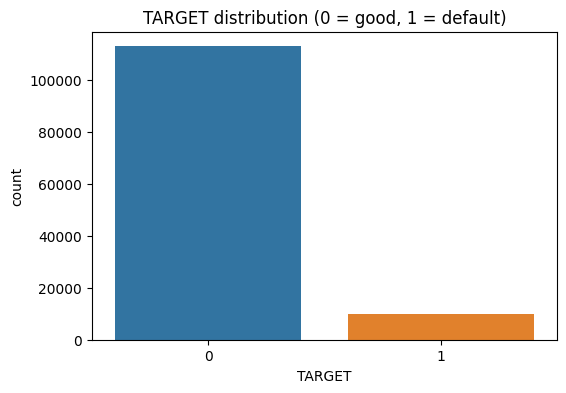

In [23]:
# Simple plots (only if running interactively)
try:
    plt.figure(figsize=(6,4))
    sns.countplot(x=y)
    plt.title("TARGET distribution (0 = good, 1 = default)")
    plt.show()
except Exception:
    pass

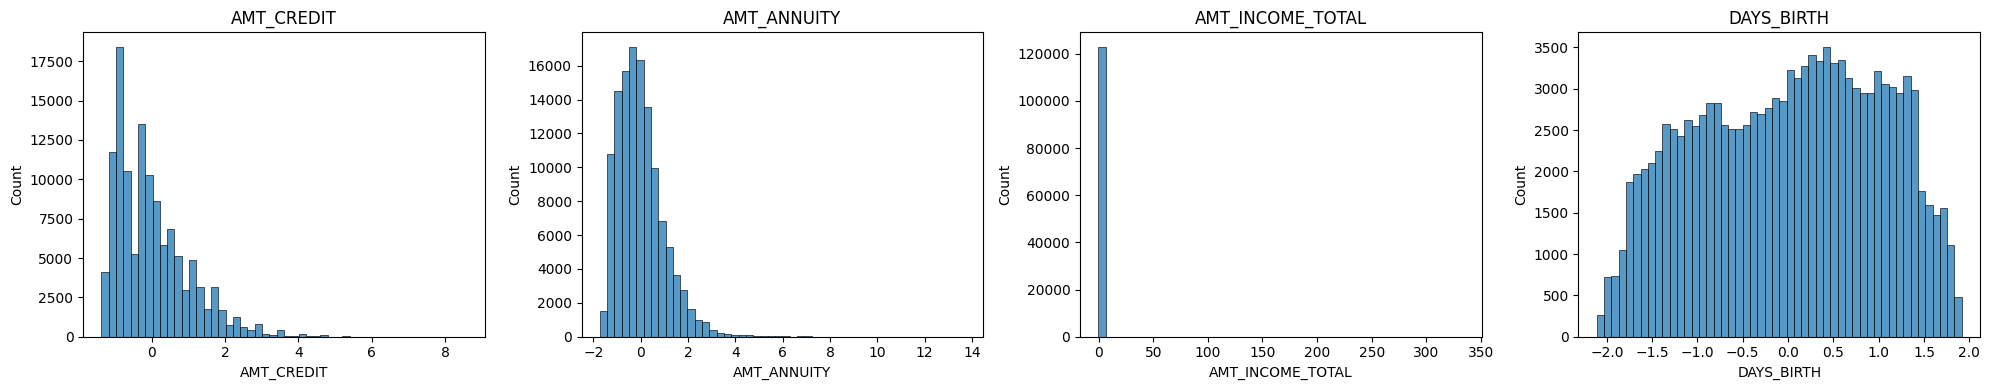

In [24]:
# Distribution plots for a few representative numeric columns if they exist
inspect_cols = [c for c in ['AMT_CREDIT','AMT_ANNUITY','AMT_INCOME_TOTAL','DAYS_BIRTH'] if c in X_proc.columns]
if inspect_cols:
    fig, axes = plt.subplots(1, len(inspect_cols), figsize=(5*len(inspect_cols), 4))
    if len(inspect_cols) == 1:
        axes = [axes]
    for ax, c in zip(axes, inspect_cols):
        sns.histplot(X_proc[c].dropna(), bins=50, ax=ax)
        ax.set_title(c)
    plt.tight_layout()
    plt.show()

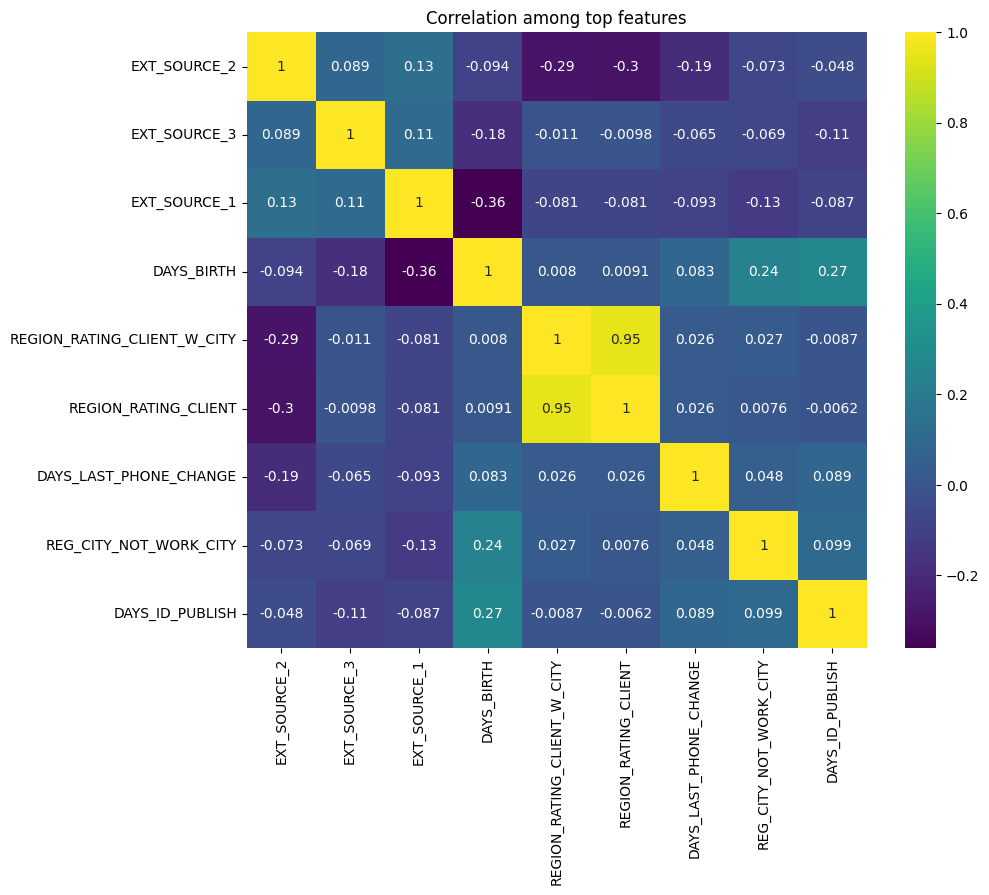

In [25]:
top_feats = [col for col in corrs.head(10).index.tolist() if col in X_proc.columns]

if len(top_feats) > 1:
    plt.figure(figsize=(10,8))
    sns.heatmap(X_proc[top_feats].corr(), annot=True, cmap='viridis')
    plt.title("Correlation among top features")
    plt.show()


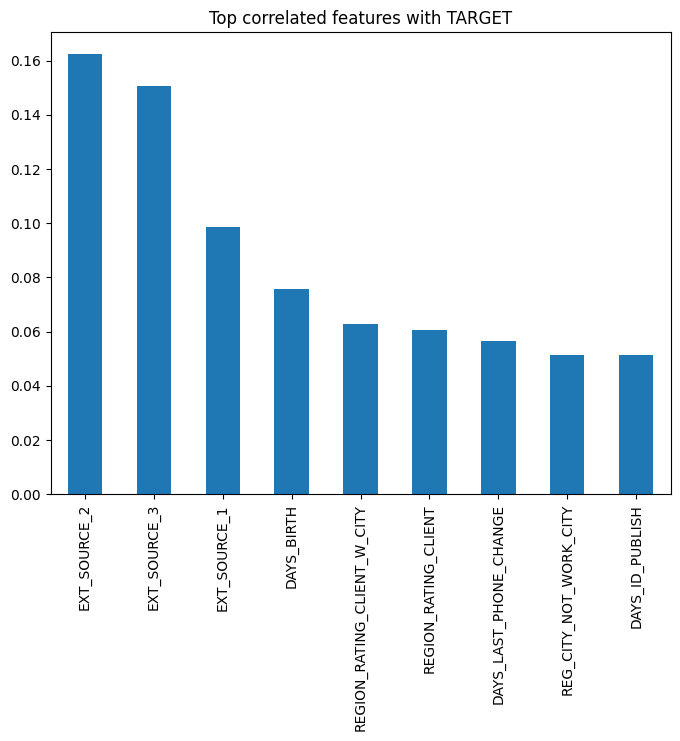

In [26]:
plt.figure(figsize=(8,6))
corrs.head(10).drop("TARGET", errors="ignore").plot(kind="bar")
plt.title("Top correlated features with TARGET")
plt.show()


<h2>Modelling</h2>

In [27]:
# 4.0 Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_proc, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (98403, 122) Test shape: (24601, 122)


In [28]:
USE_SMOTE = True
if USE_SMOTE:
    print("Applying SMOTE to training set...")
    sm = SMOTE(random_state=RANDOM_STATE)  # removed n_jobs
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    print("After SMOTE train shape:", X_train_res.shape)
else:
    X_train_res, y_train_res = X_train, y_train

Applying SMOTE to training set...
After SMOTE train shape: (180806, 122)


In [29]:
# Helper evaluation function
def evaluate_model(name, y_true, y_proba, y_pred):
    roc = roc_auc_score(y_true, y_proba)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n--- {name} ---")
    print(f"ROC-AUC: {roc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")
    print("Classification report:\n", classification_report(y_true, y_pred))
    # PR AUC
    p, r, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(r, p)
    print(f"PR-AUC: {pr_auc:.4f}")

In [30]:
# 4.2 Baseline: Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE)
lr.fit(X_train_res, y_train_res)
y_proba_lr = lr.predict_proba(X_test)[:, 1]
y_pred_lr = (y_proba_lr >= 0.5).astype(int)
evaluate_model("LogisticRegression", y_test, y_proba_lr, y_pred_lr)


--- LogisticRegression ---
ROC-AUC: 0.6904  Precision: 0.1536  Recall: 0.5060  F1: 0.2357
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.75      0.84     22601
           1       0.15      0.51      0.24      2000

    accuracy                           0.73     24601
   macro avg       0.55      0.63      0.54     24601
weighted avg       0.88      0.73      0.79     24601

PR-AUC: 0.1760


In [31]:
# 4.3 RandomForest
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, class_weight='balanced', random_state=RANDOM_STATE)
rf.fit(X_train_res, y_train_res)
y_proba_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_proba_rf >= 0.5).astype(int)
evaluate_model("RandomForest", y_test, y_proba_rf, y_pred_rf)


--- RandomForest ---
ROC-AUC: 0.6983  Precision: 0.2597  Recall: 0.0300  F1: 0.0538
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.96     22601
           1       0.26      0.03      0.05      2000

    accuracy                           0.91     24601
   macro avg       0.59      0.51      0.50     24601
weighted avg       0.87      0.91      0.88     24601

PR-AUC: 0.1689


In [32]:
# 4.4 XGBoost (sklearn API)
xgb_clf = xgb.XGBClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=6,
    use_label_encoder=False, eval_metric='auc', random_state=RANDOM_STATE
)
xgb_clf.fit(X_train_res, y_train_res)
y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_proba_xgb >= 0.5).astype(int)
evaluate_model("XGBoost", y_test, y_proba_xgb, y_pred_xgb)


--- XGBoost ---
ROC-AUC: 0.7335  Precision: 0.4364  Recall: 0.0240  F1: 0.0455
Classification report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     22601
           1       0.44      0.02      0.05      2000

    accuracy                           0.92     24601
   macro avg       0.68      0.51      0.50     24601
weighted avg       0.88      0.92      0.88     24601

PR-AUC: 0.2184


In [33]:
# 4.5 LightGBM
lgb_train = lgb.Dataset(X_train_res, label=y_train_res)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'seed': RANDOM_STATE
}
lgb_model = lgb.train(params, lgb_train, num_boost_round=200)
y_proba_lgb = lgb_model.predict(X_test)
y_pred_lgb = (y_proba_lgb >= 0.5).astype(int)
evaluate_model("LightGBM", y_test, y_proba_lgb, y_pred_lgb)


--- LightGBM ---
ROC-AUC: 0.7403  Precision: 0.5493  Recall: 0.0195  F1: 0.0377
Classification report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     22601
           1       0.55      0.02      0.04      2000

    accuracy                           0.92     24601
   macro avg       0.73      0.51      0.50     24601
weighted avg       0.89      0.92      0.88     24601

PR-AUC: 0.2286


In [34]:
# Compare models by ROC-AUC
model_scores = {
    'LogisticRegression': roc_auc_score(y_test, y_proba_lr),
    'RandomForest': roc_auc_score(y_test, y_proba_rf),
    'XGBoost': roc_auc_score(y_test, y_proba_xgb),
    'LightGBM': roc_auc_score(y_test, y_proba_lgb),
}
print("\nModel ROC-AUC summary:", model_scores)
best_name = max(model_scores, key=model_scores.get)
print("Best model by ROC-AUC:", best_name)


Model ROC-AUC summary: {'LogisticRegression': 0.6903554267510288, 'RandomForest': 0.6983062032653422, 'XGBoost': 0.733539323481262, 'LightGBM': 0.7402623335250653}
Best model by ROC-AUC: LightGBM


In [35]:
best_model_obj = {'LogisticRegression': lr, 'RandomForest': rf, 'XGBoost': xgb_clf, 'LightGBM': lgb_model}[best_name]
os.makedirs("models", exist_ok=True)
joblib.dump(best_model_obj, f"models/best_model_{best_name}.pkl")
joblib.dump(scaler, "models/scaler.pkl")
print("Saved best model & scaler to ./models/")

Saved best model & scaler to ./models/


<h2>Model Explainability</h2>

In [36]:
print("\n--- SHAP Explainability ---")
# For tree models, use TreeExplainer; for sklearn LR use KernelExplainer (slower)
if best_name in ['RandomForest', 'XGBoost', 'LightGBM']:
    if best_name == 'LightGBM':
        explainer = shap.TreeExplainer(lgb_model)
        # shap expects original feature matrix (not scaled) for good plots; we will use X_test (scaled) but it's fine
        shap_values = explainer.shap_values(X_test)
        # shap_values shape differs: for binary classification shap returns array of two arrays; pick index 1
        if isinstance(shap_values, list) and len(shap_values) == 2:
            shap_vals = shap_values[1]
        else:
            shap_vals = shap_values
    else:
        explainer = shap.TreeExplainer(best_model_obj)
        shap_vals = explainer.shap_values(X_test)
        if isinstance(shap_vals, list) and len(shap_vals) == 2:
            shap_vals = shap_vals[1]
else:
    # fallback (logistic)
    explainer = shap.KernelExplainer(best_model_obj.predict_proba, shap.sample(X_train_res, 100))
    shap_vals = explainer.shap_values(shap.sample(X_test, 100))


--- SHAP Explainability ---


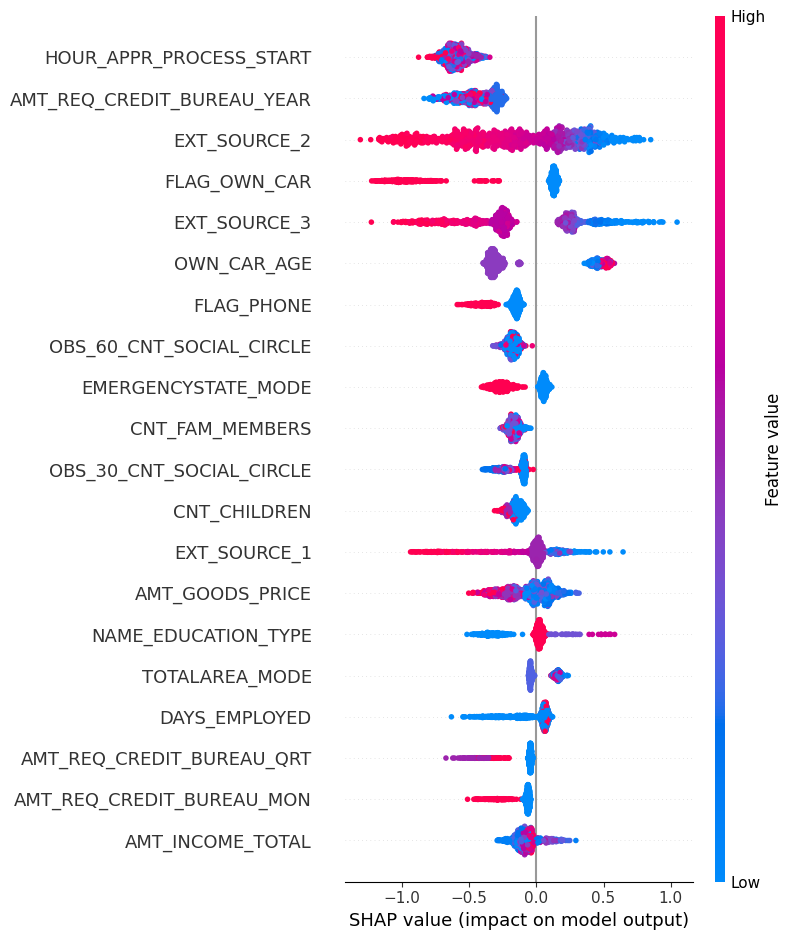

In [37]:
# Global summary plot (take subset for speed)
sample_idx = np.random.choice(X_test.shape[0], size=min(1000, X_test.shape[0]), replace=False)
shap.summary_plot(shap_vals[sample_idx], X_test.iloc[sample_idx], show=True)


In [38]:
# Local explanation (force plot) for first test row
i = 0
print(f"\nLocal explanation for test index {X_test.index[i]} (first row):")
shap.initjs()
# If shap_vals is 2D per-class, pass appropriate values
try:
    shap.force_plot(explainer.expected_value if hasattr(explainer, 'expected_value') else explainer.expected_value[1],
                    shap_vals[i], X_test.iloc[i], matplotlib=True, show=True)
except Exception:
    # fallback simple bar of feature contributions
    local_shap = pd.Series(shap_vals[i], index=X_test.columns).sort_values(ascending=False)
    print(local_shap.head(10))


Local explanation for test index 111399 (first row):


OWN_CAR_AGE               0.501652
EXT_SOURCE_3              0.256488
EXT_SOURCE_1              0.123070
DAYS_EMPLOYED             0.060216
AMT_CREDIT                0.056767
NAME_CONTRACT_TYPE        0.055050
EMERGENCYSTATE_MODE       0.053608
DAYS_ID_PUBLISH           0.049092
DAYS_LAST_PHONE_CHANGE    0.018534
loan_to_income_ratio      0.012220
dtype: float64


<h2>dataset Aggreation for better result</h2>

In [39]:
# Load main datasets
app_train = pd.read_csv("/kaggle/input/loan-default/home-credit-default-risk/application_train.csv")
app_test = pd.read_csv("/kaggle/input/loan-default/home-credit-default-risk/application_test.csv")

In [40]:
# Load auxiliary datasets

bureau = pd.read_csv("/kaggle/input/loan-default/home-credit-default-risk/bureau.csv")
bb = pd.read_csv("/kaggle/input/loan-default/home-credit-default-risk/bureau_balance.csv")
prev = pd.read_csv("/kaggle/input/loan-default/home-credit-default-risk/previous_application.csv")
pos = pd.read_csv("/kaggle/input/loan-default/home-credit-default-risk/POS_CASH_balance.csv")
inst = pd.read_csv("/kaggle/input/loan-default/home-credit-default-risk/installments_payments.csv")
cc = pd.read_csv("/kaggle/input/loan-default/home-credit-default-risk/credit_card_balance.csv")

In [41]:
# Bureau Balance → Bureau

bb_agg = bb.groupby("SK_ID_BUREAU").agg({
    "MONTHS_BALANCE": ["min", "max", "size"],
    "STATUS": ["nunique"]
})
bb_agg.columns = ["BB_" + "_".join(col).upper() for col in bb_agg.columns]
bureau = bureau.merge(bb_agg, on="SK_ID_BUREAU", how="left")

In [42]:
# Bureau per SK_ID_CURR
bureau_agg = bureau.groupby("SK_ID_CURR").agg({
    "DAYS_CREDIT": ["mean", "min", "max"],
    "CREDIT_DAY_OVERDUE": ["max", "mean"],
    "AMT_CREDIT_SUM": ["mean", "sum"],
    "AMT_CREDIT_SUM_DEBT": ["mean", "sum"],
    "CREDIT_ACTIVE": ["nunique"],
    "SK_ID_BUREAU": ["count"]
})
bureau_agg.columns = ["BUREAU_" + "_".join(col).upper() for col in bureau_agg.columns]

In [43]:
# Previous Applications
prev_agg = prev.groupby("SK_ID_CURR").agg({
    "AMT_ANNUITY": ["mean", "max"],
    "AMT_CREDIT": ["mean", "max", "min"],
    "AMT_DOWN_PAYMENT": ["mean"],
    "AMT_GOODS_PRICE": ["mean"],
    "HOUR_APPR_PROCESS_START": ["mean"],
    "NFLAG_INSURED_ON_APPROVAL": ["mean"],
    "NAME_CONTRACT_STATUS": ["nunique"],
    "SK_ID_PREV": ["count"]
})
prev_agg.columns = ["PREV_" + "_".join(col).upper() for col in prev_agg.columns]


In [44]:
# POS Cash Balance

pos_agg = pos.groupby("SK_ID_CURR").agg({
    "MONTHS_BALANCE": ["mean", "max"],
    "CNT_INSTALMENT": ["mean", "max"],
    "CNT_INSTALMENT_FUTURE": ["mean", "max"],
    "SK_ID_PREV": ["nunique", "count"]
})
pos_agg.columns = ["POS_" + "_".join(col).upper() for col in pos_agg.columns]

In [45]:
# Installments Payments
# ================================
inst_agg = inst.groupby("SK_ID_CURR").agg({
    "NUM_INSTALMENT_VERSION": ["nunique"],
    "NUM_INSTALMENT_NUMBER": ["max"],
    "DAYS_INSTALMENT": ["mean", "min", "max"],
    "DAYS_ENTRY_PAYMENT": ["mean", "min", "max"],
    "AMT_INSTALMENT": ["mean", "max", "sum"],
    "AMT_PAYMENT": ["mean", "max", "sum"]
})
inst_agg.columns = ["INST_" + "_".join(col).upper() for col in inst_agg.columns]

In [46]:
# Credit Card Balance
# ================================
cc_agg = cc.groupby("SK_ID_CURR").agg({
    "MONTHS_BALANCE": ["mean", "max"],
    "AMT_BALANCE": ["mean", "max"],
    "AMT_CREDIT_LIMIT_ACTUAL": ["mean"],
    "AMT_DRAWINGS_ATM_CURRENT": ["mean", "max"],
    "AMT_DRAWINGS_CURRENT": ["mean", "max"],
    "AMT_PAYMENT_CURRENT": ["mean", "sum"],
    "AMT_RECEIVABLE_PRINCIPAL": ["mean"],
    "AMT_TOTAL_RECEIVABLE": ["mean"],
    "CNT_DRAWINGS_ATM_CURRENT": ["mean", "max"],
    "CNT_DRAWINGS_CURRENT": ["mean", "max"],
    "SK_ID_PREV": ["nunique", "count"]
})
cc_agg.columns = ["CC_" + "_".join(col).upper() for col in cc_agg.columns]

In [47]:
# Merge all aggregations into train/test
# ================================
def merge_features(app, dfs):
    for df in dfs:
        app = app.merge(df, on="SK_ID_CURR", how="left")
    return app

In [48]:
# List of aggregated feature tables
agg_dfs = [bureau_agg, prev_agg, pos_agg, inst_agg, cc_agg]

train_merged = merge_features(app_train, agg_dfs)
test_merged = merge_features(app_test, agg_dfs)

In [49]:
# Save final enriched datasets
# ================================
train_merged.to_csv("train_merged.csv", index=False)
test_merged.to_csv("test_merged.csv", index=False)

print("✅ train_merged.csv and test_merged.csv created with enriched features!")

✅ train_merged.csv and test_merged.csv created with enriched features!


In [59]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_recall_curve
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [52]:
#merge aggreagated data
train = pd.read_csv("train_merged.csv")  # enriched training set
test = pd.read_csv("test_merged.csv")    # enriched test set

y = train["TARGET"]
X = train.drop(columns=["TARGET"])

In [54]:


# Encode categorical features
for col in X.select_dtypes("object").columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

In [56]:
# Fill missing values with median
X = X.fillna(X.median())
test_X = test.drop(columns=["SK_ID_CURR"])
test_X = test_X.fillna(test_X.median())

In [67]:
# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test)

# Save the fitted scaler for later use in Step 4
joblib.dump(scaler, "/kaggle/working/scaler.pkl")
print("Scaler saved at /kaggle/working/scaler.pkl")

# Split for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


Scaler saved at /kaggle/working/scaler.pkl


In [60]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "LightGBM": LGBMClassifier(n_estimators=500, learning_rate=0.05, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=500, learning_rate=0.05, use_label_encoder=False,
        eval_metric="logloss", random_state=42
    )
}

In [61]:
results = {"Model": [], "ROC AUC": [], "PR AUC": [], "F1": []}
fitted_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    preds_proba = model.predict_proba(X_val)[:, 1]
    
    roc_auc = roc_auc_score(y_val, preds_proba)
    pr_auc = average_precision_score(y_val, preds_proba)
    f1 = f1_score(y_val, preds)
    
    results["Model"].append(name)
    results["ROC AUC"].append(roc_auc)
    results["PR AUC"].append(pr_auc)
    results["F1"].append(f1)
    
    fitted_models[name] = model


In [62]:
# Results DataFrame
results_df = pd.DataFrame(results)
print("\nModel Comparison:\n", results_df)


Model Comparison:
                  Model   ROC AUC    PR AUC        F1
0  Logistic Regression  0.763312  0.243967  0.271301
1             LightGBM  0.777445  0.274860  0.073823
2              XGBoost  0.778478  0.276089  0.078578


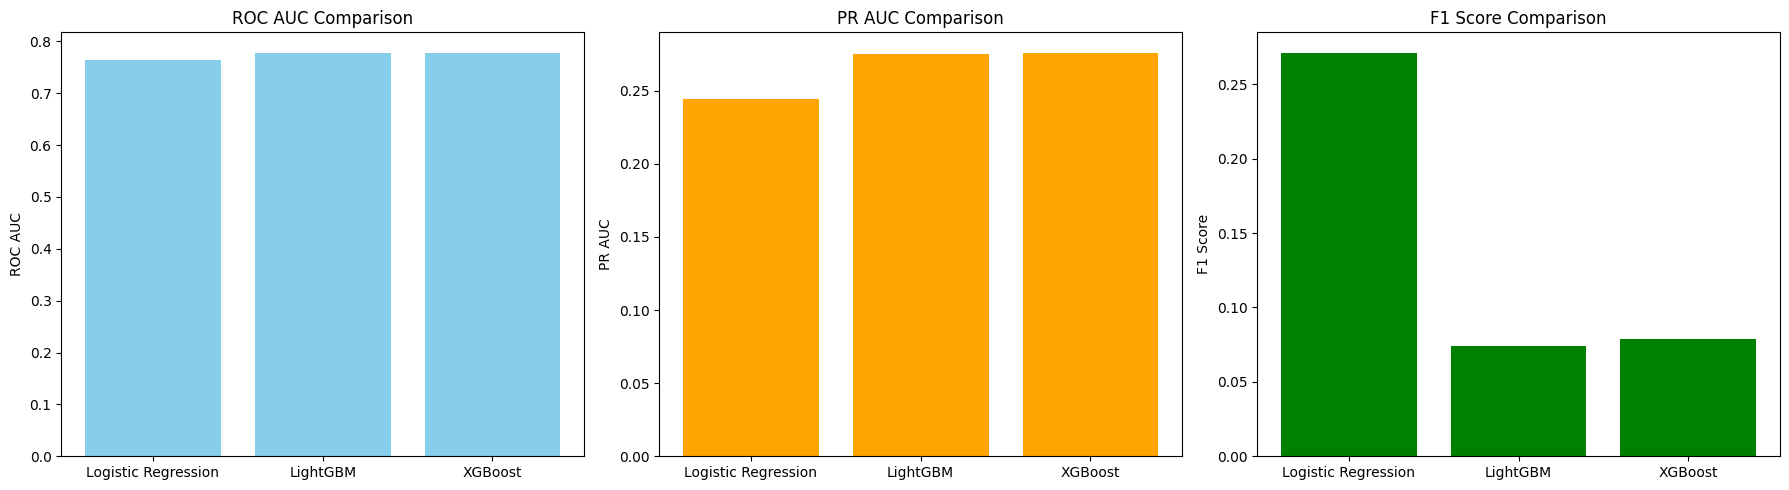

In [63]:
#Visualization


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ROC AUC Bar Plot
axes[0].bar(results_df["Model"], results_df["ROC AUC"], color="skyblue")
axes[0].set_title("ROC AUC Comparison")
axes[0].set_ylabel("ROC AUC")

# PR AUC Bar Plot
axes[1].bar(results_df["Model"], results_df["PR AUC"], color="orange")
axes[1].set_title("PR AUC Comparison")
axes[1].set_ylabel("PR AUC")

# F1 Bar Plot
axes[2].bar(results_df["Model"], results_df["F1"], color="green")
axes[2].set_title("F1 Score Comparison")
axes[2].set_ylabel("F1 Score")

plt.tight_layout()
plt.show()

In [64]:
# Pick best model by ROC AUC (fallback PR AUC if tie)
best_model_name = results_df.sort_values(
    by=["ROC AUC", "PR AUC"], ascending=False
).iloc[0]["Model"]

best_model = fitted_models[best_model_name]
print(f"\n✅ Best Model: {best_model_name}")

# Save model
joblib.dump(best_model, f"best_model_{best_model_name.replace(' ', '_')}.pkl")
print(f"Model saved as best_model_{best_model_name.replace(' ', '_')}.pkl")


✅ Best Model: XGBoost
Model saved as best_model_XGBoost.pkl
